In [13]:
import matplotlib.pyplot as plt
import numpy as np
import os

In [14]:
import numpy as np
import math

def sigma_k_two_terms(k: int, k_star: int, k_prime: int, a1: float, a2: float) -> float:
    """sigma_k = a1 * k_star! * delta_{k_star,k} + a2 * (k_star + k_prime)! * delta_{k_star+k_prime,k}"""
    big_k = k_star + k_prime
    term_1 = 0
    term_2 = 0
    #if big_k ==  k_star and k == big_k:
    #    return a1 * float(math.factorial(k_star)) + a2 * float(math.factorial(big_k))
    
    if k == big_k:
        term_2 = a2 * float(math.factorial(big_k))
    
    if k == k_star:
        term_1 = a1 * float(math.factorial(k_star))
    
    return term_1 + term_2

def sigma_r_k_two_terms(k: int, k_star: int, k_prime: int, r: float, a1: float, a2: float) -> float:
    """sigma^{[r]}_k = r^k * (term from k_star + term from k_star+k_prime) with parity checks"""
    out = 0.0
    # first term from k_star
    diff1 = k_star - k
    if diff1 >= 0 and (diff1 % 2) == 0:
        m = diff1 // 2
        out += a1 * math.factorial(k_star) * (r ** k) * (((r - 1) / 2) ** m) / math.factorial(m)
    # second term from big_k = k_star + k_prime
    big_k = k_star + k_prime
    diff2 = big_k - k
    if diff2 >= 0 and (diff2 % 2) == 0:
        m2 = diff2 // 2
        out += a2 * math.factorial(big_k) * (r ** k) * (((r - 1) / 2) ** m2) / math.factorial(m2)
    return float(out)

def bar_sigma_r_k_two_terms(k: int, k_star: int, k_prime: int, r: float, a1: float, a2: float) -> float:
    """\bar{\sigma}^{[r]}_k following formula: each Hermite gives two possible contributions (k and k-2 shifts)."""
    out = 0.0
    # first Hermite (k_star)
    diff1 = k_star - k
    if diff1 >= 0 and (diff1 % 2) == 0:
        m = diff1 // 2
        term1 = ((r - 1) / 2) ** m / math.factorial(m)
        out += a1 * (r ** k) * ( math.factorial(k_star) * k_star * term1 )
    diff1b = k_star - k - 2
    if diff1b >= 0 and (diff1b % 2) == 0:
        m1b = diff1b // 2
        term1b = ((r - 1) / 2) ** m1b / math.factorial(m1b)
        out += a1 * (r ** k) * ( math.factorial(k_star) * term1b )

    # second Hermite (k_star + k_prime)
    big_k = k_star + k_prime
    diff2 = big_k - k
    if diff2 >= 0 and (diff2 % 2) == 0:
        m2 = diff2 // 2
        term2 = ((r - 1) / 2) ** m2 / math.factorial(m2)
        out += a2 * (r ** k) * ( math.factorial(big_k) * big_k * term2 )
    diff2b = big_k - k - 2
    if diff2b >= 0 and (diff2b % 2) == 0:
        m2b = diff2b // 2
        term2b = ((r - 1) / 2) ** m2b / math.factorial(m2b)
        out += a2 * (r ** k) * ( math.factorial(big_k) * term2b )

    return float(out)

def compute_A_B_two_terms(
    mu: float,
    k_star: int,
    k_prime: int,
    r: float,
    a1: float,
    a2: float,
    max_k: int = None
):
    """Compute raw A and B sums truncated at max_k (defaults to k_star + k_prime)."""
    if mu == 0:
        raise ValueError("mu must be nonzero.")
    if max_k is None:
        max_k = k_star + k_prime
    else:
        max_k = min(max_k, k_star + k_prime)

    ks = np.arange(0, max_k + 1, dtype=int)
    sigma_vals = np.array([sigma_k_two_terms(k, k_star, k_prime, a1, a2) for k in ks], dtype=float)
    sigma_r_vals = np.array([sigma_r_k_two_terms(k, k_star, k_prime, r, a1, a2) for k in ks], dtype=float)
    bar_sigma_r_vals = np.array([bar_sigma_r_k_two_terms(k, k_star, k_prime, r, a1, a2) for k in ks], dtype=float)

    A_sum = 0.0
    B_sum = 0.0

    for idx, k in enumerate(ks):
        k_fact = float(math.factorial(k))
        mu_k = mu ** k
        mu_kp1 = mu ** (k + 1)
        mu_2k_p2 = mu ** (2 * k + 2)

        bar_s_r_k = bar_sigma_r_vals[idx]
        s_r_k = sigma_r_vals[idx]
        s_k = sigma_vals[idx]

        innerA = -s_k + (s_r_k / mu_k if mu_k != 0 else np.inf)
        termA = - (bar_s_r_k / (k_fact * mu_kp1)) * innerA
        A_sum += termA

        termB_first = (bar_s_r_k * s_r_k) / (k_fact * mu_2k_p2)
        termB_second = 0.0
        if k >= 1 and s_k != 0.0:
            km1_fact = float(math.gamma(k))  # (k-1)!
            second_inner = s_r_k - (bar_s_r_k / k)
            termB_second = (s_k / (km1_fact * (mu ** (k + 2)))) * second_inner

        B_sum += - (termB_first + termB_second)

    return float(A_sum), float(B_sum)

# ----------------- Numeric equality test -----------------
def test_equivalence(mu_values):
    diffs_A = []
    diffs_B = []
    for mu in mu_values:
        # Case 1: first-term only He_{1}
        A1, B1 = compute_A_B_two_terms(mu=mu, k_star=2, k_prime=0, r=mu**2, a1=1.0, a2=0.0)
        # Case 2: second-term only He_{0+1} (i.e. He_1)
        A2, B2 = compute_A_B_two_terms(mu=mu, k_star=0, k_prime=2, r=mu**2, a1=0.0, a2=1.0)
        diffs_A.append(abs(A1 - A2))
        diffs_B.append(abs(B1 - B2))
    return max(diffs_A), max(diffs_B)

if __name__ == "__main__":
    mus = np.linspace(0.1, 0.9, 21)
    max_diff_A, max_diff_B = test_equivalence(mus)
    print("max |A_case1 - A_case2| =", max_diff_A)
    print("max |B_case1 - B_case2| =", max_diff_B)
    # Expect values ~1e-15..1e-12 (floating rounding). If larger, there's a bug.

max |A_case1 - A_case2| = 0.0
max |B_case1 - B_case2| = 0.0


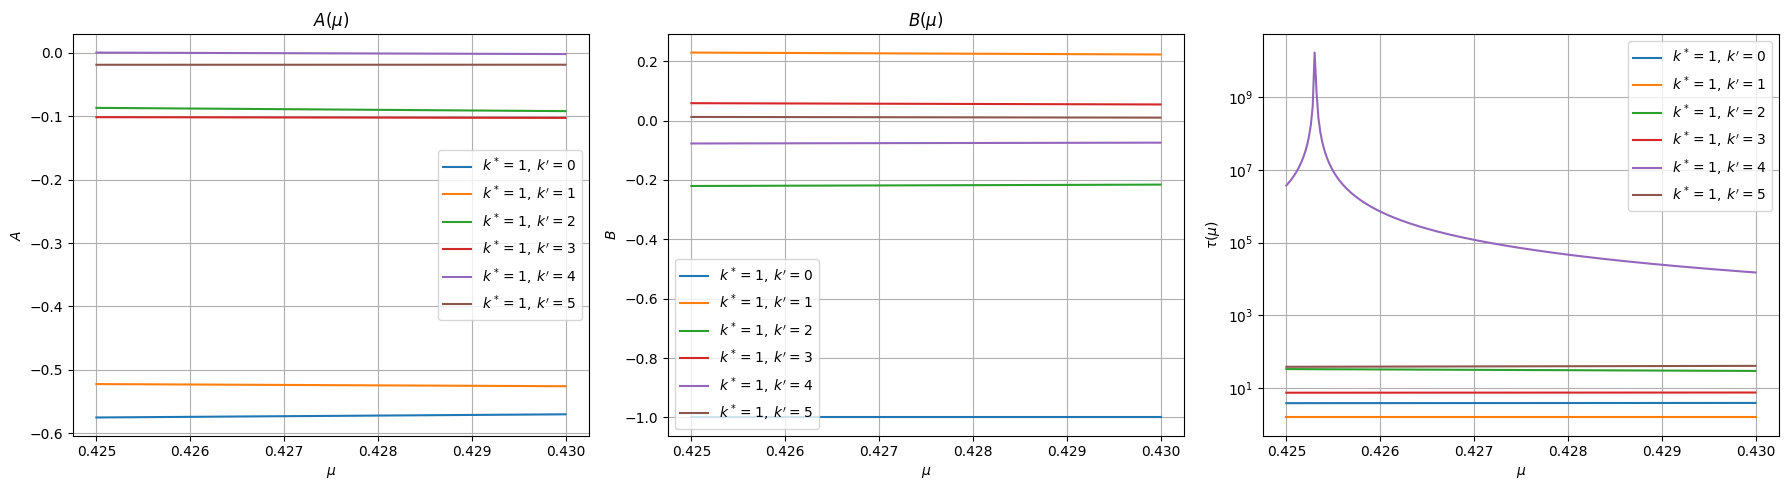

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Use the two-term version implemented earlier
# from your_module import compute_A_B_two_terms

# Sweep mu:
mu_values = np.linspace(0.425, 0.43, 250)

# Parameters
k_star = 1             # fixed Hermite order for first term
k_prime_list = [0, 1, 2, 3, 4, 5] #, 1, 2, 3, 5]   #[0, 1, 2, 3] ← iterate over several k'
a_1_val = 0.0
a_2_val = 1.0           # change to 0.0 to test pure single Hermite
# r = mu^2, so we set inside loop

A_results = {kp: [] for kp in k_prime_list}
B_results = {kp: [] for kp in k_prime_list}

for k_prime in k_prime_list:
    for mu_val in mu_values:
        A_val, B_val = compute_A_B_two_terms(
            mu=mu_val,
            k_star=k_star,
            k_prime=k_prime,
            r=mu_val**2,
            a1=a_1_val,
            a2=a_2_val
        )
        A_results[k_prime].append(A_val)
        B_results[k_prime].append(B_val)

# Convert to arrays
for kp in k_prime_list:
    if a_2_val !=0:
        A_results[kp] = np.array(A_results[kp]) /(math.factorial((k_star+kp))*(k_star+kp)) 
        B_results[kp] = np.array(B_results[kp])  /(math.factorial((k_star+kp))*(k_star+kp)) 
    else:
        A_results[kp] = np.array(A_results[kp]) /(math.factorial((k_star))*(k_star)) 
        B_results[kp] = np.array(B_results[kp])  /(math.factorial((k_star))*(k_star)) 

# ------------------ PLOTTING -------------------
plt.figure(figsize=(18,5))

# 1) Plot A(mu)
plt.subplot(1,3,1)
for kp in k_prime_list:
    plt.plot(mu_values, -A_results[kp], label=fr'$k^*={k_star},\; k^\prime={kp}$')
plt.title(r'$A(\mu)$')
plt.xlabel(r'$\mu$')
plt.ylabel(r'$A$')
plt.grid(True)
plt.legend()

# 2) Plot B(mu)
plt.subplot(1,3,2)
for kp in k_prime_list:
    plt.plot(mu_values, B_results[kp], label=fr'$k^*={k_star},\; k^\prime={kp}$')
plt.title(r'$B(\mu)$')
plt.xlabel(r'$\mu$')
plt.ylabel(r'$B$')
plt.grid(True)
plt.legend()

# 3) Plot tau(mu)
plt.subplot(1,3,3)
colors = plt.cm.turbo(np.linspace(0, 1, len(k_prime_list)))
for kp in k_prime_list:
    A = A_results[kp]
    B = B_results[kp]

    discriminant = B**2 + 4*A**2
    tau = (-B + np.sqrt(discriminant)) / (2*A**2)
    tau = np.where(np.isfinite(tau), tau, np.nan)

    plt.plot(mu_values, tau, label=fr'$k^*={k_star},\; k^\prime={kp}$')

#plt.title(r'$\tau(\mu) = \frac{-B + \sqrt{B^2 + 4A^2}}{2A^2}$')
plt.yscale("log")
plt.xlabel(r'$\mu$')
plt.ylabel(r'$\tau(\mu)$')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

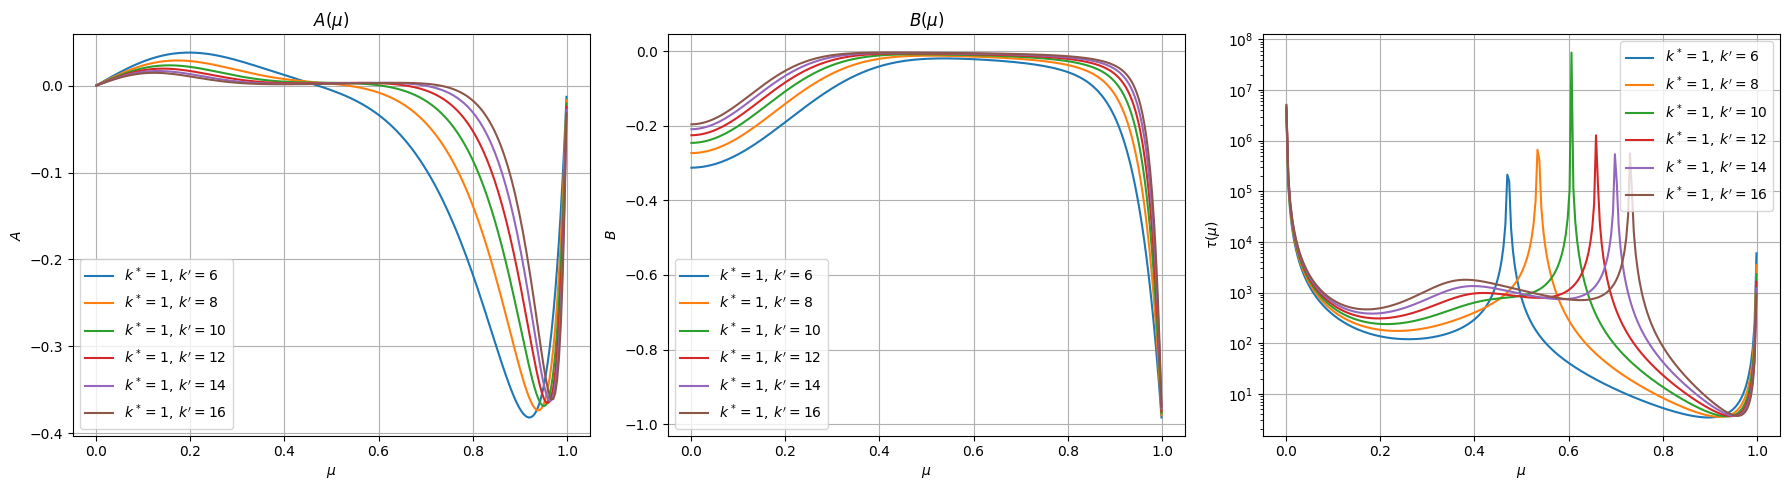

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Use the two-term version implemented earlier
# from your_module import compute_A_B_two_terms

# Sweep mu:
mu_values = np.linspace(0.001, 0.999, 250)

# Parameters
k_star = 1             # fixed Hermite order for first term
k_prime_list = [6, 8, 10, 12, 14, 16] #, 1, 2, 3, 5]   #[0, 1, 2, 3] ← iterate over several k'
a_1_val = 0.0
a_2_val = 1.0           # change to 0.0 to test pure single Hermite
# r = mu^2, so we set inside loop

A_results = {kp: [] for kp in k_prime_list}
B_results = {kp: [] for kp in k_prime_list}

for k_prime in k_prime_list:
    for mu_val in mu_values:
        A_val, B_val = compute_A_B_two_terms(
            mu=mu_val,
            k_star=k_star,
            k_prime=k_prime,
            r=mu_val**2,
            a1=a_1_val,
            a2=a_2_val
        )
        A_results[k_prime].append(A_val)
        B_results[k_prime].append(B_val)

# Convert to arrays
for kp in k_prime_list:
    if a_2_val !=0:
        A_results[kp] = np.array(A_results[kp]) /(math.factorial((k_star+kp))*(k_star+kp)) 
        B_results[kp] = np.array(B_results[kp])  /(math.factorial((k_star+kp))*(k_star+kp)) 
    else:
        A_results[kp] = np.array(A_results[kp]) /(math.factorial((k_star))*(k_star)) 
        B_results[kp] = np.array(B_results[kp])  /(math.factorial((k_star))*(k_star)) 

# ------------------ PLOTTING -------------------
plt.figure(figsize=(18,5))

# 1) Plot A(mu)
plt.subplot(1,3,1)
for kp in k_prime_list:
    plt.plot(mu_values, -A_results[kp], label=fr'$k^*={k_star},\; k^\prime={kp}$')
plt.title(r'$A(\mu)$')
plt.xlabel(r'$\mu$')
plt.ylabel(r'$A$')
plt.grid(True)
plt.legend()

# 2) Plot B(mu)
plt.subplot(1,3,2)
for kp in k_prime_list:
    plt.plot(mu_values, B_results[kp], label=fr'$k^*={k_star},\; k^\prime={kp}$')
plt.title(r'$B(\mu)$')
plt.xlabel(r'$\mu$')
plt.ylabel(r'$B$')
plt.grid(True)
plt.legend()

# 3) Plot tau(mu)
plt.subplot(1,3,3)
colors = plt.cm.turbo(np.linspace(0, 1, len(k_prime_list)))
for kp in k_prime_list:
    A = A_results[kp]
    B = B_results[kp]

    discriminant = B**2 + 4*A**2
    tau = (-B + np.sqrt(discriminant)) / (2*A**2)
    tau = np.where(np.isfinite(tau), tau, np.nan)

    plt.plot(mu_values, tau, label=fr'$k^*={k_star},\; k^\prime={kp}$')

#plt.title(r'$\tau(\mu) = \frac{-B + \sqrt{B^2 + 4A^2}}{2A^2}$')
plt.yscale("log")
plt.xlabel(r'$\mu$')
plt.ylabel(r'$\tau(\mu)$')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Sweep mu:
#mu_values = np.linspace(0.001, 0.999, 250)
mu_values = np.linspace(0.00001, 0.9999, 250)


# Parameters
k_star_list = [0] #, 1, 2]       # <--- now multiple k_star values
k_prime_list = [22, 34, 44] #[2, 3, 4, 6, 8, 16, 22] #, 4, 5, 6, 7, 8] #, 6, 7] #, 1, 2, 3, 4, 5]
a_1_val = 0.0
a_2_val = 1.0   # set to 0 for single Hermite term

# Storage dictionaries indexed by (k_star, k_prime)
A_results = {(ks, kp): [] for ks in k_star_list for kp in k_prime_list}
B_results = {(ks, kp): [] for ks in k_star_list for kp in k_prime_list}

for k_star in k_star_list:
    for k_prime in k_prime_list:
        for mu_val in mu_values:

            A_val, B_val = compute_A_B_two_terms(
                mu=mu_val,
                k_star=k_star,
                k_prime=k_prime,
                r=mu_val**2,
                a1=a_1_val,
                a2=a_2_val
            )

            A_results[(k_star, k_prime)].append(A_val)
            B_results[(k_star, k_prime)].append(B_val)

# Normalize and convert to arrays
for k_star in k_star_list:
    for k_prime in k_prime_list:
        
        if k_prime==0 and k_star==0:
            continue
        
        A = np.array(A_results[(k_star, k_prime)])
        B = np.array(B_results[(k_star, k_prime)])

        if a_2_val != 0:
            if k_star + k_prime == 0:
                norm=1
            else:
                norm = math.factorial(k_star + k_prime) * (k_star + k_prime)
        else:
            if k_star != 0:
                norm = math.factorial(k_star) * k_star
            else:
                norm = 1
        
        A_results[(k_star, k_prime)] = A / norm
        B_results[(k_star, k_prime)] = B / norm

/var/folders/r2/0ryqb7352pj4s03jv51f3w180000gn/T/ipykernel_14985/451031405.py:105: RuntimeWarning: invalid value encountered in scalar divide
  termB_first = (bar_s_r_k * s_r_k) / (k_fact * mu_2k_p2)


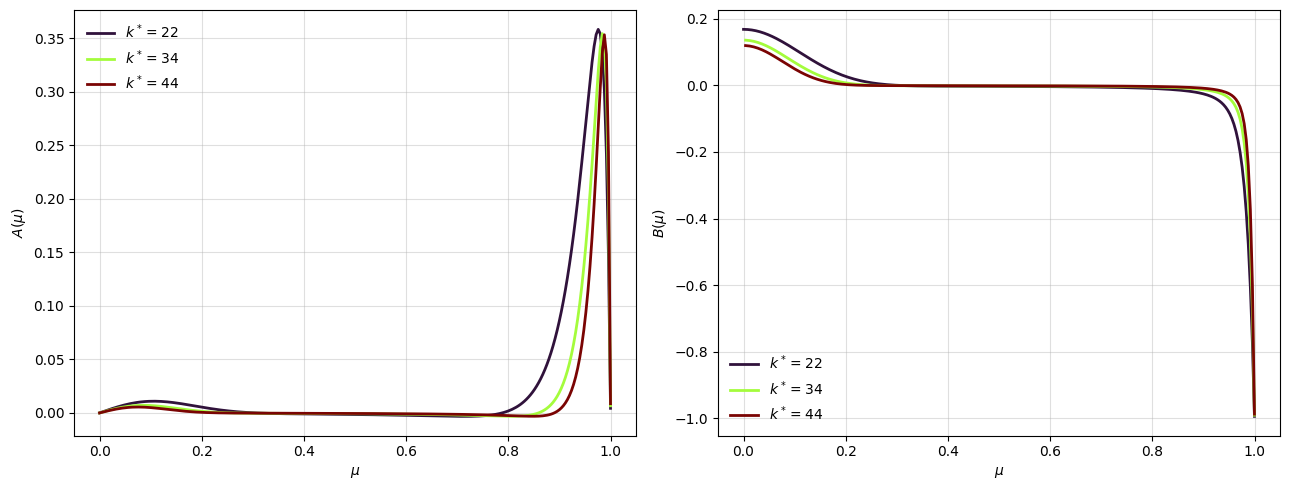

In [33]:
# ------------------ PLOTTING A(mu) and B(mu) SIDE-BY-SIDE PER k* -------------------

num_rows = len(k_star_list)
plt.figure(figsize=(13, 5 * num_rows))   # widen for readability

colors = plt.cm.turbo(np.linspace(0, 1, len(k_prime_list)))

for idx_k, k_star in enumerate(k_star_list):

    # ---------- COLUMN 1: A(mu) ----------
    plt.subplot(num_rows, 2, 2*idx_k + 1)
    for idx_p, k_prime in enumerate(k_prime_list):

        if k_prime + k_star == 0 and k_star == 0:
            continue

        A = A_results[(k_star, k_prime)]
        plt.plot(mu_values, A,
                 label=fr"$k^*={k_prime}$",
                 linewidth=2,
                 color=colors[idx_p])

    #plt.title(fr"$A(\mu)$  (k^* = {k_star})")
    plt.xlabel(r'$\mu$')
    plt.ylabel(r'$A(\mu)$')
    #plt.yscale("log")
    plt.grid(True, alpha=0.4)
    plt.legend(frameon=False)

    # ---------- COLUMN 2: B(mu) ----------
    plt.subplot(num_rows, 2, 2*idx_k + 2)
    for idx_p, k_prime in enumerate(k_prime_list):

        if k_prime + k_star == 0 and k_star == 0:
            continue

        B = B_results[(k_star, k_prime)]
        plt.plot(mu_values, B,
                 label=fr"$k^*={k_prime}$",
                 linewidth=2,
                 linestyle="-",
                 color=colors[idx_p])

    #plt.title(fr"$B(\mu)$  (k^* = {k_star})")
    plt.xlabel(r'$\mu$')
    plt.ylabel(r'$B(\mu)$')
    plt.grid(True, alpha=0.4)
    plt.legend(frameon=False)

plt.tight_layout()
plt.show()

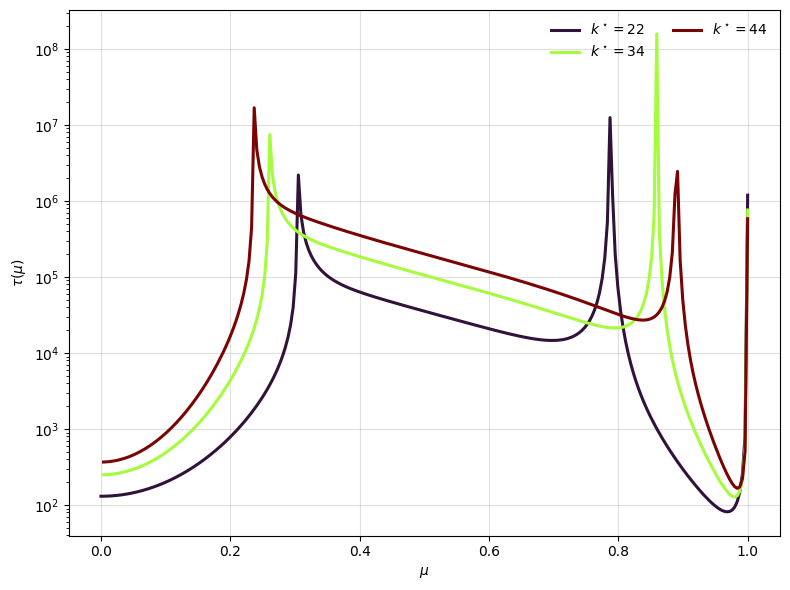

In [34]:
# ------------------ PLOTTING -------------------

num_subplots = len(k_star_list)
plt.figure(figsize=(8 * num_subplots, 6))

#colors = plt.cm.tab20(np.linspace(0, 1, len(k_prime_list)))  # bright color palette
colors = plt.cm.turbo(np.linspace(0, 1, len(k_prime_list)))

for i, k_star in enumerate(k_star_list, start=1):
    plt.subplot(1, num_subplots, i)

    for idx, k_prime in enumerate(k_prime_list):
        
        
        if k_prime+k_star==0 and k_star==0:
            continue
        
        A = A_results[(k_star, k_prime)]
        B = B_results[(k_star, k_prime)]
        discriminant = B**2 + 4*A**2
        tau = (-B + np.sqrt(discriminant)) / (2*A**2)
        tau = np.where(np.isfinite(tau), tau, np.nan)

        plt.plot(mu_values, (k_star+k_prime)*tau,
                 label=fr"$k^\star = {k_star+k_prime}$",
                 linewidth=2.2,
                 color=colors[idx])   # bright color applied here

    plt.yscale("log")
    plt.xlabel(r'$\mu$')
    plt.ylabel(r'$\tau(\mu)$')
    plt.grid(True, alpha=0.4)

    plt.legend(
        loc='upper right',
        ncol=2,
        frameon=False
    )

plt.tight_layout()
plt.show()

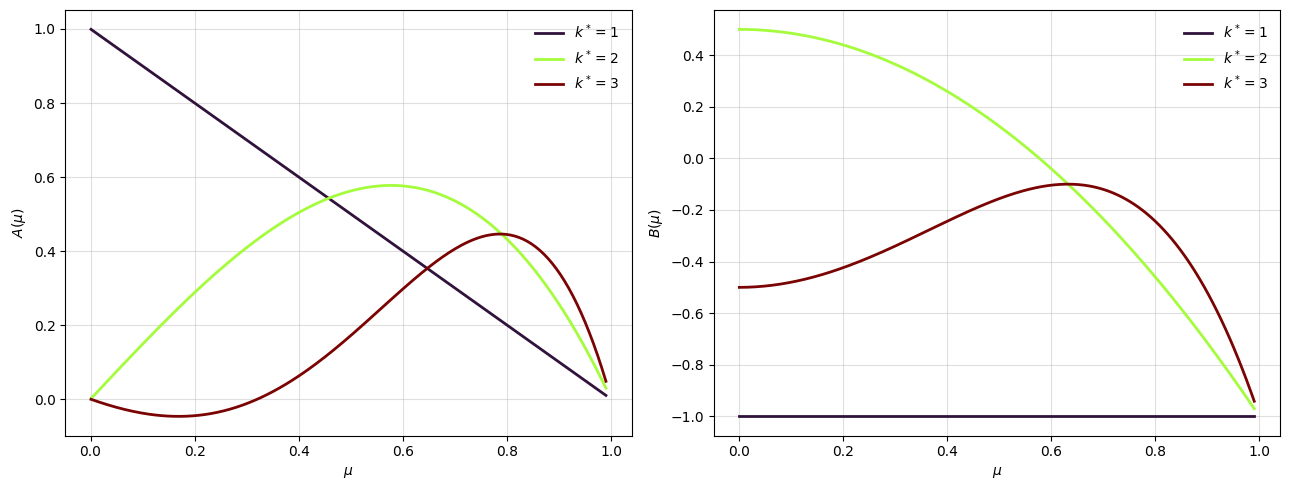

In [6]:
# ------------------ PLOTTING A(mu) and B(mu) SIDE-BY-SIDE PER k* -------------------

num_rows = len(k_star_list)
plt.figure(figsize=(13, 5 * num_rows))   # widen for readability

colors = plt.cm.turbo(np.linspace(0, 1, len(k_prime_list)))

for idx_k, k_star in enumerate(k_star_list):

    # ---------- COLUMN 1: A(mu) ----------
    plt.subplot(num_rows, 2, 2*idx_k + 1)
    for idx_p, k_prime in enumerate(k_prime_list):

        if k_prime + k_star == 0 and k_star == 0:
            continue

        A = A_results[(k_star, k_prime)]
        plt.plot(mu_values, A,
                 label=fr"$k^*={k_prime}$",
                 linewidth=2,
                 color=colors[idx_p])

    #plt.title(fr"$A(\mu)$  (k^* = {k_star})")
    plt.xlabel(r'$\mu$')
    plt.ylabel(r'$A(\mu)$')
    plt.grid(True, alpha=0.4)
    plt.legend(frameon=False)

    # ---------- COLUMN 2: B(mu) ----------
    plt.subplot(num_rows, 2, 2*idx_k + 2)
    for idx_p, k_prime in enumerate(k_prime_list):

        if k_prime + k_star == 0 and k_star == 0:
            continue

        B = B_results[(k_star, k_prime)]
        plt.plot(mu_values, B,
                 label=fr"$k^*={k_prime}$",
                 linewidth=2,
                 linestyle="-",
                 color=colors[idx_p])

    #plt.title(fr"$B(\mu)$  (k^* = {k_star})")
    plt.xlabel(r'$\mu$')
    plt.ylabel(r'$B(\mu)$')
    plt.grid(True, alpha=0.4)
    plt.legend(frameon=False)

plt.tight_layout()
plt.show()

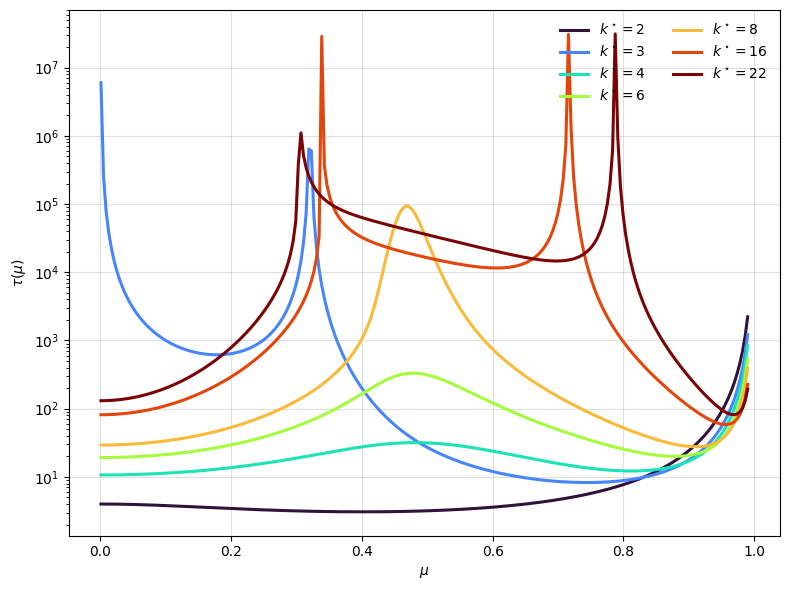

In [21]:
# ------------------ PLOTTING -------------------

num_subplots = len(k_star_list)
plt.figure(figsize=(8 * num_subplots, 6))

#colors = plt.cm.tab20(np.linspace(0, 1, len(k_prime_list)))  # bright color palette
colors = plt.cm.turbo(np.linspace(0, 1, len(k_prime_list)))

for i, k_star in enumerate(k_star_list, start=1):
    plt.subplot(1, num_subplots, i)

    for idx, k_prime in enumerate(k_prime_list):
        
        
        if k_prime+k_star==0 and k_star==0:
            continue
        
        A = A_results[(k_star, k_prime)]
        B = B_results[(k_star, k_prime)]
        discriminant = B**2 + 4*A**2
        tau = (-B + np.sqrt(discriminant)) / (2*A**2)
        tau = np.where(np.isfinite(tau), tau, np.nan)

        plt.plot(mu_values, (k_star+k_prime)*tau,
                 label=fr"$k^\star = {k_star+k_prime}$",
                 linewidth=2.2,
                 color=colors[idx])   # bright color applied here

    plt.yscale("log")
    plt.xlabel(r'$\mu$')
    plt.ylabel(r'$\tau(\mu)$')
    plt.grid(True, alpha=0.4)

    plt.legend(
        loc='upper right',
        ncol=2,
        frameon=False
    )

plt.tight_layout()
plt.show()

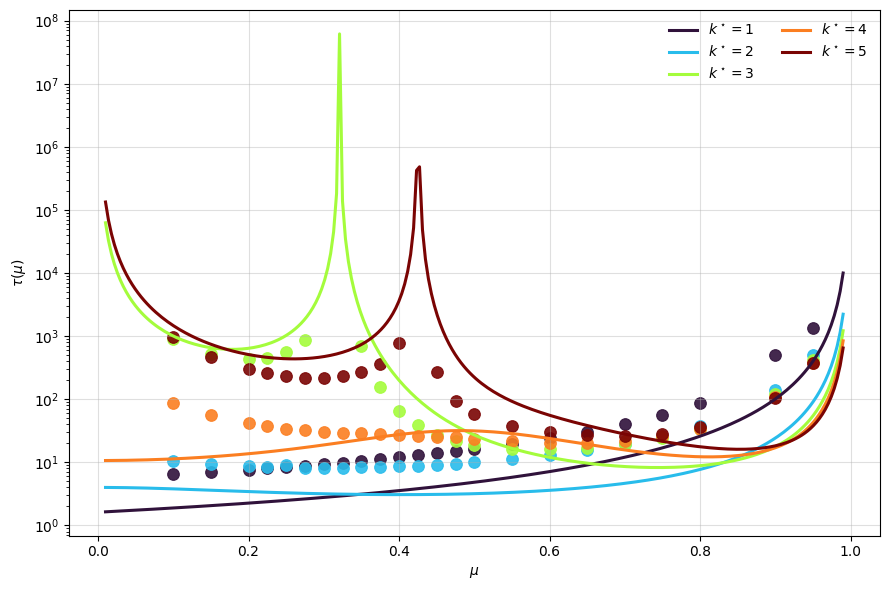

In [18]:
# ------------------ LOAD NUMERICAL DATA -------------------
evidence_path = "time_to_overlap_by_k.npz"
evidence_data = np.load(evidence_path)

# ------------------ PLOTTING -------------------
num_subplots = len(k_star_list)
plt.figure(figsize=(9 * num_subplots, 6))

colors = plt.cm.turbo(np.linspace(0, 1, len(k_prime_list)))

for i, k_star in enumerate(k_star_list, start=1):
    plt.subplot(1, num_subplots, i)

    for idx, k_prime in enumerate(k_prime_list):
        
        k = k_star + k_prime
        if k == 0 and k_star == 0:
            continue
        
        # ---- Theoretical τ(μ) curve ----
        A = A_results[(k_star, k_prime)]
        B = B_results[(k_star, k_prime)]
        discriminant = B**2 + 4*A**2
        tau = (-B + np.sqrt(discriminant)) / (2*A**2)
        tau = np.where(np.isfinite(tau), tau, np.nan)

        plt.plot(mu_values, k*tau,
                 label=fr"$k^\star = {k}$",
                 linewidth=2.2,
                 color=colors[idx])

        # ---- Numerical Evidence (convert d → μ) ----
        key_d = f"{k}_d"
        key_t = f"{k}_t"
        if key_d in evidence_data and key_t in evidence_data:
            d_vals = evidence_data[key_d]
            t_vals = evidence_data[key_t]
            
            
            
            plt.scatter(d_vals, t_vals/(100),
                        s=70,
                        marker="o",
                        edgecolor=colors[idx],
                        facecolor=colors[idx],
                        linewidth=0.8,
                        alpha=0.9)

    plt.yscale("log")
    plt.xlabel(r'$\mu$')
    plt.ylabel(r'$\tau(\mu)$')
    plt.grid(True, alpha=0.4)

    plt.legend(
        loc='upper right',
        ncol=2,
        frameon=False
    )

plt.tight_layout()
#plt.savefig("charateristic_time_pure_hermite.pdf")
plt.show()

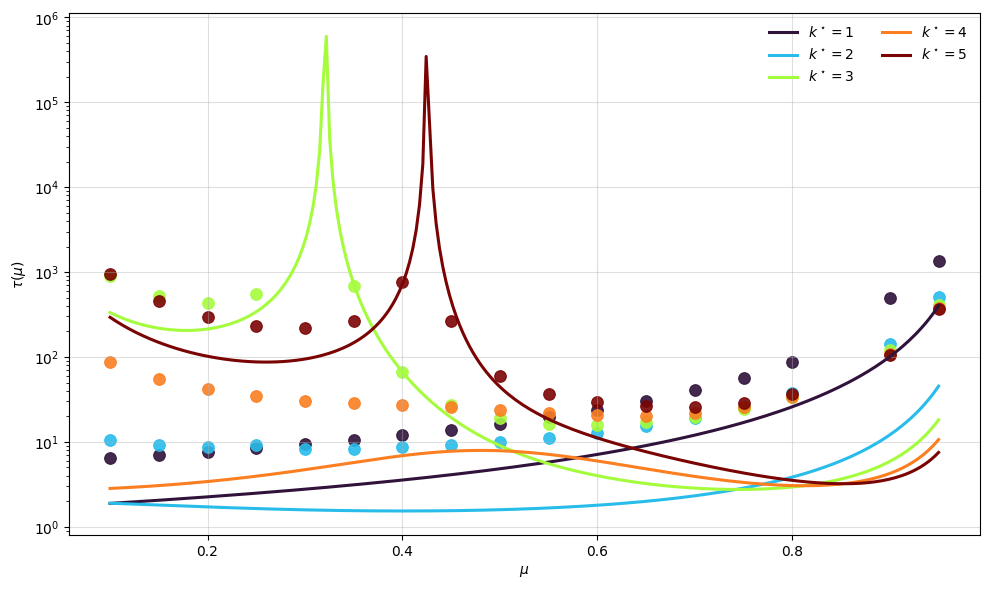

In [19]:
# ------------------ LOAD NUMERICAL DATA -------------------
evidence_path = "time_to_overlap_by_k.npz"
evidence_data = np.load(evidence_path)

# ------------------ PLOTTING -------------------
num_subplots = len(k_star_list)
plt.figure(figsize=(10 * num_subplots, 6))

colors = plt.cm.turbo(np.linspace(0, 1, len(k_prime_list)))

for i, k_star in enumerate(k_star_list, start=1):
    plt.subplot(1, num_subplots, i)

    for idx, k_prime in enumerate(k_prime_list):
        
        k = k_star + k_prime
        if k == 0 and k_star == 0:
            continue
        
        # ---- Theoretical τ(μ) curve ----
        A = A_results[(k_star, k_prime)]
        B = B_results[(k_star, k_prime)]
        discriminant = B**2 + 4*A**2
        tau = (-B + np.sqrt(discriminant)) / (2*A**2)
        tau = np.where(np.isfinite(tau), tau, np.nan)

        plt.plot(mu_values, tau,
                 label=fr"$k^\star = {k}$",
                 linewidth=2.2,
                 color=colors[idx])

        # ---- Numerical Evidence (convert d → μ) ----
        key_d = f"{k}_d"
        key_t = f"{k}_t"
        if key_d in evidence_data and key_t in evidence_data:
            d_vals = evidence_data[key_d]
            t_vals = evidence_data[key_t]
            
            
            # Desired x-axis points
            desired_d = np.arange(0.1, np.max(d_vals) + 0.001, 0.05)

            # Keep only points where d_vals exactly matches the desired grid
            x_filtered = []
            y_filtered = []
            for d_target in desired_d:
                # Find indices where d_vals equals d_target
                matches = np.where(np.isclose(d_vals, d_target, atol=1e-12))[0]
                if len(matches) > 0:
                    idx_p = matches[0]
                    x_filtered.append(d_vals[idx_p])
                    y_filtered.append(t_vals[idx_p])

            # Convert lists
            x_filtered = np.array(x_filtered)
            y_filtered = np.array(y_filtered)

            mu_points = d_vals  # IMPORTANT FIX ✅

            """plt.plot(x_filtered, y_filtered/100,
                        s=70,
                        marker="o",
                        edgecolor="black",
                        facecolor=colors[idx],
                        linewidth=0.8,
                        alpha=0.9)"""
            
            plt.scatter(x_filtered, y_filtered/(100),
                        s=70,
                        marker="o",
                        edgecolor=colors[idx],
                        facecolor=colors[idx],
                        linewidth=0.8,
                        alpha=0.9)

    plt.yscale("log")
    plt.xlabel(r'$\mu$')
    plt.ylabel(r'$\tau(\mu)$')
    plt.grid(True, alpha=0.4)

    plt.legend(
        loc='upper right',
        ncol=2,
        frameon=False
    )

plt.tight_layout()
plt.savefig("charateristic_time_pure_hermite.pdf")
plt.show()

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Sweep mu:
mu_values = np.linspace(0.001, 0.999, 250)

# Parameters
k_star_list = [1] #, 1, 2]       # <--- now multiple k_star values
k_prime_list = [1, 2, 3, 4, 5, 6, 7] #, 1, 2, 3, 4, 5]
a_1_val = 1.0
a_2_val = 1.0   # set to 0 for single Hermite term

# Storage dictionaries indexed by (k_star, k_prime)
A_results = {(ks, kp): [] for ks in k_star_list for kp in k_prime_list}
B_results = {(ks, kp): [] for ks in k_star_list for kp in k_prime_list}

for k_star in k_star_list:
    for k_prime in k_prime_list:
        for mu_val in mu_values:

            A_val, B_val = compute_A_B_two_terms(
                mu=mu_val,
                k_star=k_star,
                k_prime=k_prime,
                r=mu_val**2,
                a1=a_1_val,
                a2=a_2_val
            )

            A_results[(k_star, k_prime)].append(A_val)
            B_results[(k_star, k_prime)].append(B_val)

# Normalize and convert to arrays
for k_star in k_star_list:
    for k_prime in k_prime_list:
        
        if k_prime==0 and k_star==0:
            continue
        
        A = np.array(A_results[(k_star, k_prime)])
        B = np.array(B_results[(k_star, k_prime)])

        if a_2_val != 0:
            if k_star + k_prime == 0:
                norm=1
            else:
                norm = math.factorial(k_star + k_prime) * (k_star + k_prime)
        else:
            if k_star != 0:
                norm = math.factorial(k_star) * k_star
            else:
                norm = 1
        
        A_results[(k_star, k_prime)] = A / norm
        B_results[(k_star, k_prime)] = B / norm

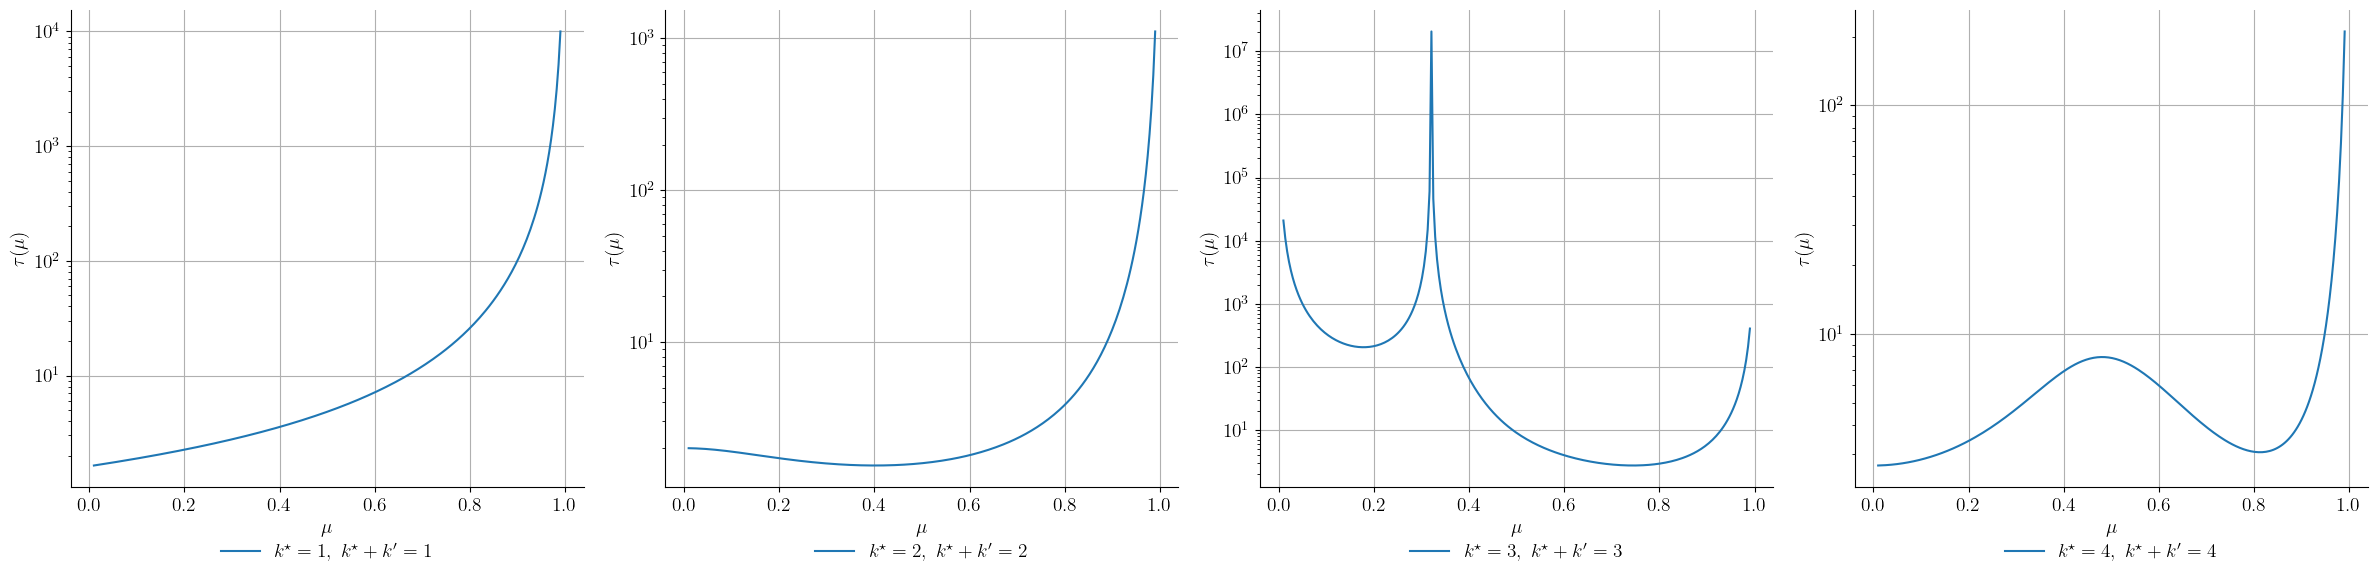

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Sweep mu:
mu_values = np.linspace(0.01, 0.99, 250)

# Parameters
k_star_list = [1, 2, 3, 4] #, 1, 2]       # <--- now multiple k_star values
k_prime_list = [0] #, 1, 2, 3, 4, 5]
a_1_val = 1.0
a_2_val = 0.0   # set to 0 for single Hermite term

# Storage dictionaries indexed by (k_star, k_prime)
A_results = {(ks, kp): [] for ks in k_star_list for kp in k_prime_list}
B_results = {(ks, kp): [] for ks in k_star_list for kp in k_prime_list}

for k_star in k_star_list:
    for k_prime in k_prime_list:
        for mu_val in mu_values:

            A_val, B_val = compute_A_B_two_terms(
                mu=mu_val,
                k_star=k_star,
                k_prime=k_prime,
                r=mu_val**2,
                a1=a_1_val,
                a2=a_2_val
            )

            A_results[(k_star, k_prime)].append(A_val)
            B_results[(k_star, k_prime)].append(B_val)

# Normalize and convert to arrays
for k_star in k_star_list:
    for k_prime in k_prime_list:
        A = np.array(A_results[(k_star, k_prime)])
        B = np.array(B_results[(k_star, k_prime)])

        if a_2_val != 0:
            if k_star + k_prime == 0:
                norm=1
            else:
                norm = math.factorial(k_star + k_prime) * (k_star + k_prime)
        else:
            if k_star != 0:
                norm = math.factorial(k_star) * k_star
            else:
                norm = 1
        
        A_results[(k_star, k_prime)] = A / norm
        B_results[(k_star, k_prime)] = B / norm

# ------------------ PLOTTING -------------------

num_subplots = len(k_star_list)
plt.figure(figsize=(6 * num_subplots, 6))
colors = plt.cm.turbo(np.linspace(0, 1, len(k_prime_list)))

for i, k_star in enumerate(k_star_list, start=1):

    plt.subplot(1, num_subplots, i)

    for idx, k_prime in enumerate(k_prime_list, start=1):
        A = A_results[(k_star, k_prime)]
        B = B_results[(k_star, k_prime)]

        discriminant = B**2 + 4*A**2
        tau = (-B + np.sqrt(discriminant)) / (2*A**2)
        tau = np.where(np.isfinite(tau), tau, np.nan)

        plt.plot(mu_values, tau, label=fr"$k^\star={k_star},\; k^\star+k'={k_prime+k_star}$") #,a_1={a_1_val}, a_2={a_2_val}$")

    #plt.title(fr"$\tau(\mu)$ for $k^* = {k_star}$")
    plt.yscale("log")
    plt.xlabel(r'$\mu$')
    plt.ylabel(r'$\tau(\mu)$')
    plt.grid(True)
    #plt.legend(ncol=2)
    # ---- Legend below each subplot ----
    plt.legend(
        loc='upper center',
        bbox_to_anchor=(0.5, -0.08),
        ncol=2,
        frameon=False
    )

plt.tight_layout()
plt.savefig("charateristic_time_mixe_hermite.pdf")
plt.show()

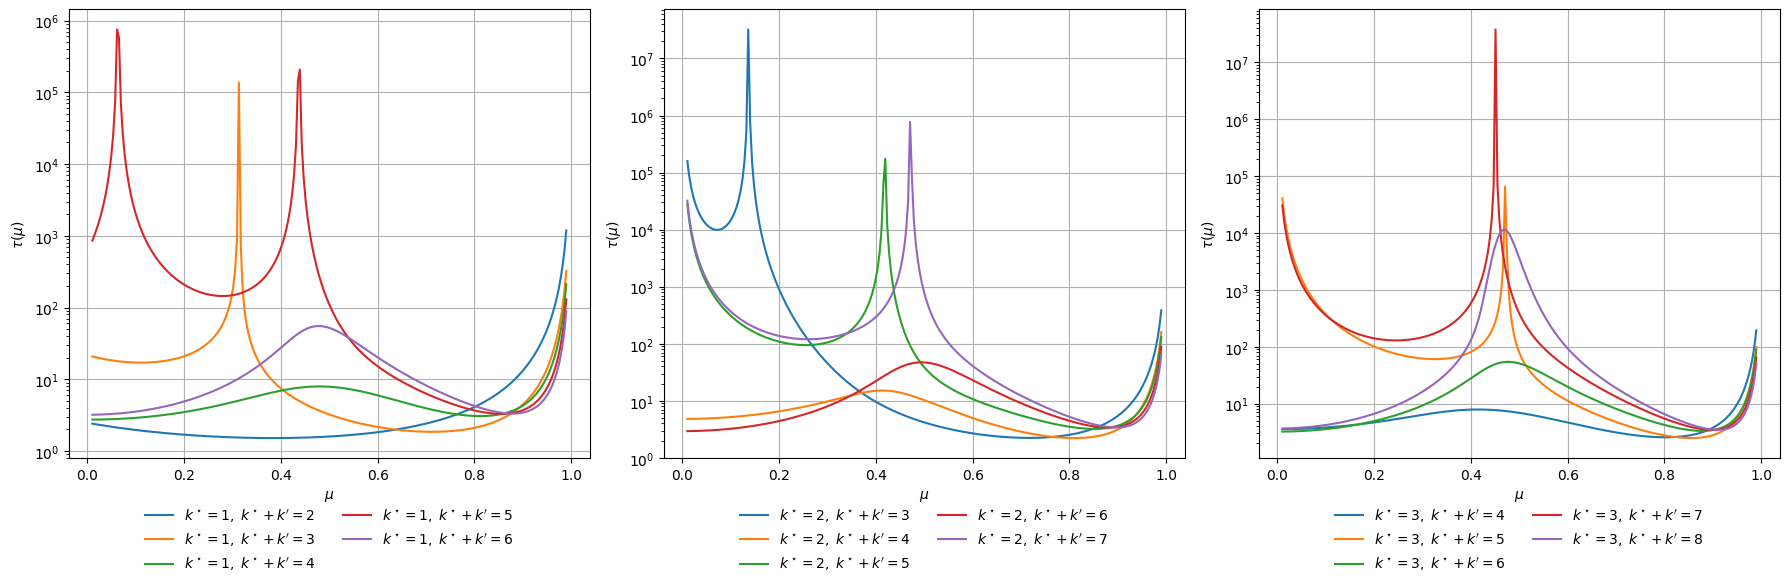

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Sweep mu:
mu_values = np.linspace(0.01, 0.99, 250)

# Parameters
k_star_list = [1, 2, 3] #, 1, 2]       # <--- now multiple k_star values
k_prime_list = [1, 2, 3, 4, 5] #, 1, 2, 3, 4, 5]
a_1_val = 1.0
a_2_val = 1.0   # set to 0 for single Hermite term

# Storage dictionaries indexed by (k_star, k_prime)
A_results = {(ks, kp): [] for ks in k_star_list for kp in k_prime_list}
B_results = {(ks, kp): [] for ks in k_star_list for kp in k_prime_list}

for k_star in k_star_list:
    for k_prime in k_prime_list:
        for mu_val in mu_values:

            A_val, B_val = compute_A_B_two_terms(
                mu=mu_val,
                k_star=k_star,
                k_prime=k_prime,
                r=mu_val**2,
                a1=a_1_val,
                a2=a_2_val
            )

            A_results[(k_star, k_prime)].append(A_val)
            B_results[(k_star, k_prime)].append(B_val)

# Normalize and convert to arrays
for k_star in k_star_list:
    for k_prime in k_prime_list:
        A = np.array(A_results[(k_star, k_prime)])
        B = np.array(B_results[(k_star, k_prime)])

        if a_2_val != 0:
            if k_star + k_prime == 0:
                norm=1
            else:
                norm = math.factorial(k_star + k_prime) * (k_star + k_prime)
        else:
            if k_star != 0:
                norm = math.factorial(k_star) * k_star
            else:
                norm = 1
        
        A_results[(k_star, k_prime)] = A / norm
        B_results[(k_star, k_prime)] = B / norm

# ------------------ PLOTTING -------------------

num_subplots = len(k_star_list)
plt.figure(figsize=(6 * num_subplots, 6))
colors = plt.cm.turbo(np.linspace(0, 1, len(k_prime_list)))

for i, k_star in enumerate(k_star_list, start=1):

    plt.subplot(1, num_subplots, i)

    for idx, k_prime in enumerate(k_prime_list, start=1):
        A = A_results[(k_star, k_prime)]
        B = B_results[(k_star, k_prime)]

        discriminant = B**2 + 4*A**2
        tau = (-B + np.sqrt(discriminant)) / (2*A**2)
        tau = np.where(np.isfinite(tau), tau, np.nan)

        plt.plot(mu_values, tau, label=fr"$k^\star={k_star},\; k^\star+k'={k_prime+k_star}$") #,a_1={a_1_val}, a_2={a_2_val}$")

    #plt.title(fr"$\tau(\mu)$ for $k^* = {k_star}$")
    plt.yscale("log")
    plt.xlabel(r'$\mu$')
    plt.ylabel(r'$\tau(\mu)$')
    plt.grid(True)
    #plt.legend(ncol=2)
    # ---- Legend below each subplot ----
    plt.legend(
        loc='upper center',
        bbox_to_anchor=(0.5, -0.08),
        ncol=2,
        frameon=False
    )

plt.tight_layout()
plt.savefig("charateristic_time_mixe_hermite.pdf")
plt.show()

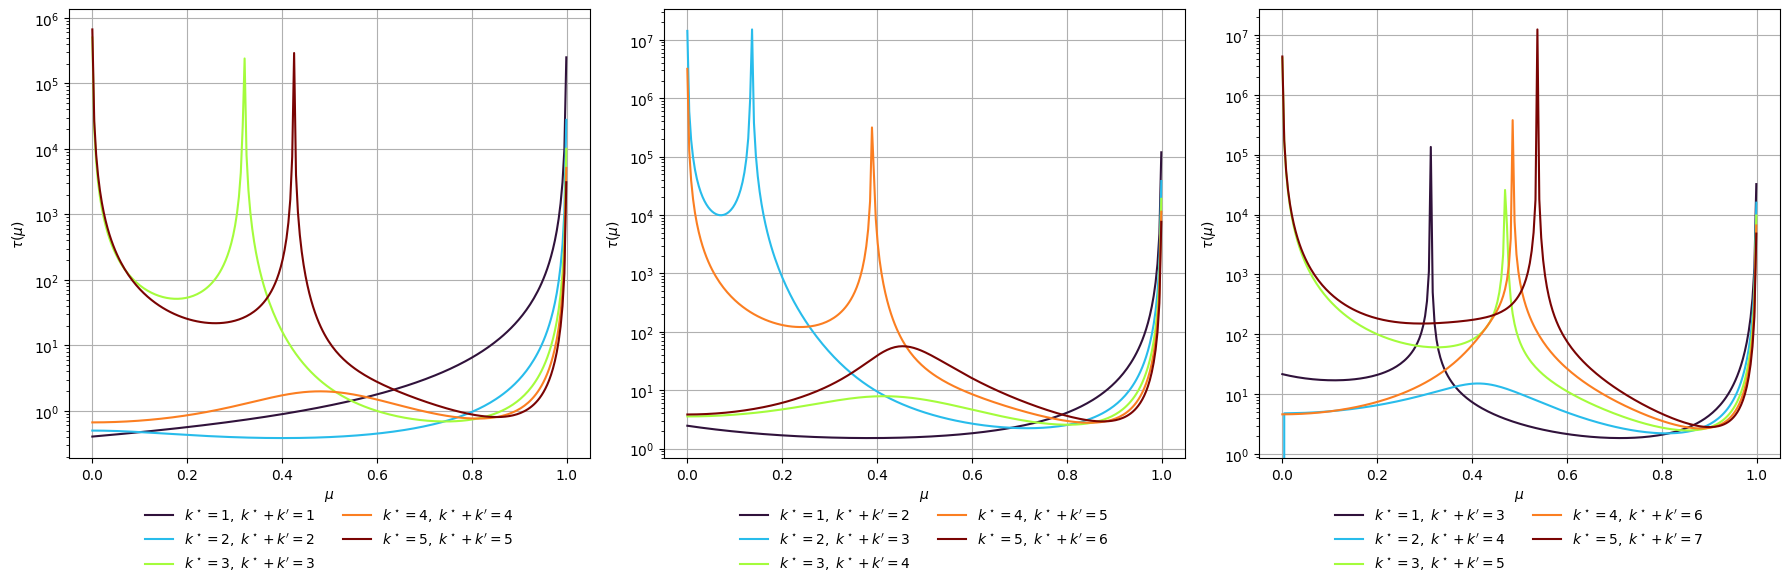

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import math

# ------------------ PARAMETERS -------------------
mu_values = np.linspace(0.001, 0.999, 250)

k_star_list = [1, 2, 3, 4, 5]             # values of k*
k_prime_list = [0, 1, 2]   # values of k'
a_1_val = 1.0
a_2_val = 1.0   # set to 0 for single Hermite term

# ------------------ STORAGE -------------------
A_results = {(ks, kp): [] for ks in k_star_list for kp in k_prime_list}
B_results = {(ks, kp): [] for ks in k_star_list for kp in k_prime_list}

# ------------------ COMPUTE A, B -------------------
for k_prime in k_prime_list:                # now fix k'
    for k_star in k_star_list:              # vary k*
        for mu_val in mu_values:

            A_val, B_val = compute_A_B_two_terms(
                mu=mu_val,
                k_star=k_star,
                k_prime=k_prime,
                r=mu_val**2,
                a1=a_1_val,
                a2=a_2_val
            )

            A_results[(k_star, k_prime)].append(A_val)
            B_results[(k_star, k_prime)].append(B_val)

# ------------------ NORMALIZATION -------------------
for k_prime in k_prime_list:
    for k_star in k_star_list:
        A = np.array(A_results[(k_star, k_prime)])
        B = np.array(B_results[(k_star, k_prime)])

        if a_2_val != 0:
            if k_star + k_prime == 0:
                norm = 1
            else:
                norm = math.factorial(k_star + k_prime) * (k_star + k_prime)
        else:
            if k_star != 0:
                norm = math.factorial(k_star) * k_star
            else:
                norm = 1

        A_results[(k_star, k_prime)] = A / norm
        B_results[(k_star, k_prime)] = B / norm

# ------------------ PLOTTING -------------------
num_subplots = len(k_prime_list)
plt.figure(figsize=(6 * num_subplots, 6))

colors = plt.cm.turbo(np.linspace(0, 1, len(k_star_list)))

for i, k_prime in enumerate(k_prime_list, start=1):

    plt.subplot(1, num_subplots, i)

    for idx, k_star in enumerate(k_star_list, start=1):
        A = A_results[(k_star, k_prime)]
        B = B_results[(k_star, k_prime)]

        discriminant = B**2 + 4*A**2
        tau = (-B + np.sqrt(discriminant)) / (2 * A**2)
        tau = np.where(np.isfinite(tau), tau, np.nan)

        plt.plot(mu_values, tau, color=colors[idx-1],
                 label=fr"$k^\star={k_star},\; k^\star+k'={k_prime+k_star}$")

    plt.yscale("log")
    plt.xlabel(r'$\mu$')
    plt.ylabel(r'$\tau(\mu)$')
    plt.grid(True)

    plt.legend(
        loc='upper center',
        bbox_to_anchor=(0.5, -0.08),
        ncol=2,
        frameon=False
    )

plt.tight_layout()
plt.savefig("characteristic_time_fixed_kprime.pdf")
plt.show()

In [16]:
import numpy as np, math

def diagnose_equivalence(k_star_A, k_prime_A, a1a2_A, k_star_B, k_prime_B, a1a2_B, mu=0.5, r=None, max_k=120, tol=1e-10):
    if r is None:
        r = mu**2

    # build arrays for A
    ks = np.arange(0, k_prime_A+k_star_A)
    a1, a2 = a1a2_A
    sigma_A = np.array([sigma_k_two_terms(int(k), k_star_A, k_prime_A, a1, a2) for k in ks], float)
    sigma_r_A = np.array([sigma_r_k_two_terms(int(k), k_star_A, k_prime_A, r, a1, a2) for k in ks], float)
    bar_sigma_r_A = np.array([bar_sigma_r_k_two_terms(int(k), k_star_A, k_prime_A, r, a1, a2) for k in ks], float)

    # build arrays for B
    b1, b2 = a1a2_B
    sigma_B = np.array([sigma_k_two_terms(int(k), k_star_B, k_prime_B, b1, b2) for k in ks], float)
    sigma_r_B = np.array([sigma_r_k_two_terms(int(k), k_star_B, k_prime_B, r, b1, b2) for k in ks], float)
    bar_sigma_r_B = np.array([bar_sigma_r_k_two_terms(int(k), k_star_B, k_prime_B, r, b1, b2) for k in ks], float)

    # quick equality check of the sigma arrays
    def first_diff_arr(Aarr, Barr, name):
        diff = np.abs(Aarr - Barr)
        idx = np.where(diff > tol)[0]
        if idx.size:
            i = int(idx[0])
            return i, diff[i], Aarr[i], Barr[i]
        return None

    for name, Aarr, Barr in [
        ("sigma", sigma_A, sigma_B),
        ("sigma_r", sigma_r_A, sigma_r_B),
        ("bar_sigma_r", bar_sigma_r_A, bar_sigma_r_B),
    ]:
        fd = first_diff_arr(Aarr, Barr, name)
        if fd:
            i,d,v1,v2 = fd
            print(f"Mismatch in {name} at k={i}: |Δ|={d:.3e}")
            print("  valA =", v1, "  valB =", v2)
            return False

    # compute per-k contributions to A and B (exact same formula used in compute_A_B_two_terms)
    def per_k_contribs(sigma_arr, sigma_r_arr, bar_sigma_arr, mu):
        perA = []
        perBfirst = []
        perBsecond = []
        for k in ks:
            kf = float(math.factorial(k))
            mu_k = mu**k if k>0 else 1.0
            mu_kp1 = mu**(k+1)
            mu_2k_p2 = mu**(2*k + 2)
            s_k = sigma_arr[k]; s_r_k = sigma_r_arr[k]; bar_s = bar_sigma_arr[k]
            innerA = -s_k + (s_r_k / mu_k if mu_k != 0 else np.inf)
            tA = - (bar_s / (kf * mu_kp1)) * innerA
            perA.append(tA)
            tBf = (bar_s * s_r_k) / (kf * mu_2k_p2)
            perBfirst.append(tBf)
            tBs = 0.0
            if k >= 1 and s_k != 0.0:
                km1 = float(math.gamma(k))
                tBs = (s_k / (km1 * (mu ** (k + 2)))) * (s_r_k - (bar_s / k))
            perBsecond.append(tBs)
        return np.array(perA), np.array(perBfirst), np.array(perBsecond)

    perA_A, perBf_A, perBs_A = per_k_contribs(sigma_A, sigma_r_A, bar_sigma_r_A, mu)
    perA_B, perBf_B, perBs_B = per_k_contribs(sigma_B, sigma_r_B, bar_sigma_r_B, mu)

    for name, Arr, Brr in [
        ("perA", perA_A, perA_B),
        ("perBfirst", perBf_A, perBf_B),
        ("perBsecond", perBs_A, perBs_B),
    ]:
        fd = first_diff_arr(Arr, Brr, name)
        if fd:
            i,d,v1,v2 = fd
            print(f"Mismatch in {name} at k={i}: |Δ|={d:.3e}")
            print("  valA =", v1, "  valB =", v2)
            # also print neighborhood
            start = max(0, i-2); end = min(len(ks)-1, i+2)
            print("neighborhood (k, A, B):")
            for j in range(start, end+1):
                print(f"  k={j:2d}  {Arr[j]:12.6e}  {Brr[j]:12.6e}")
            return False

    # final sums
    A_A = perA_A.sum()
    B_A = - (perBf_A + perBs_A).sum()
    A_B = perA_B.sum()
    B_B = - (perBf_B + perBs_B).sum()

    print("Final A/B comparison:")
    print(f" A_A = {A_A:.6e}   A_B = {A_B:.6e}   ΔA = {A_A-A_B:.3e}")
    print(f" B_A = {B_A:.6e}   B_B = {B_B:.6e}   ΔB = {B_A-B_B:.3e}")

    # check if any final normalizations are applied in your code (search for these lines)
    print("\nChecklist reminders:")
    print("- Did you apply any final normalization like dividing by factorial(k_star)*k_star? (search code)")
    print("- Did you pass same max_k into both compute calls used for plotting?")

    return True

# Example run: compare your two representations
# Case A: k_star=2, k'= -2? (you meant k_star=2, k_star+k'=0 -> that implies k' = -2 which is weird)
# Based on your message scenario: compare (k_star=2,k'=0,a1=1,a2=1) vs (k_star=0,k'=2,a1=1,a2=1)
print("RUNNING DIAGNOSTIC:")
diagnose_equivalence(k_star_A=2, k_prime_A=0, a1a2_A=(1.0,1.0),
                     k_star_B=0, k_prime_B=2, a1a2_B=(1.0,1.0),
                     mu=0.5, max_k=120, tol=1e-10)

RUNNING DIAGNOSTIC:
Mismatch in sigma at k=0: |Δ|=1.000e+00
  valA = 0.0   valB = 1.0


False

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import math

# (reuse your compute_A_B and sigma, sigma_r, bar_sigma_r definitions above)

# Sweep mu:
#mu_values = np.linspace(0.6, 0.9, 250)  # avoid mu=0 to avoid 0^k instability
mu_values = np.linspace(0.2, 0.42, 250)  # avoid mu=0 to avoid 0^k instability


# Choose the values of f_k to compare:
f_k_values = [1,2, 3] #, 2, 3, 4, 5] #[1, 2, 3, 4 ]#, 4, 5]
k_p_val = 0   # <-- fix or change as you like
a_1_val = 1.0
a_2_val = 0.0

A_results = {f: [] for f in f_k_values}
B_results = {f: [] for f in f_k_values}

for f_k_val in f_k_values:
    for mu_val in mu_values:
        A_val, B_val, _ = compute_A_B(mu=mu_val, k_star=f_k_val, r=mu_val**2)
        A_results[f_k_val].append(A_val)
        B_results[f_k_val].append(B_val)

# Convert to arrays
for f in f_k_values:
    A_results[f] = np.array(A_results[f]) #/(math.factorial(f)*f)
    B_results[f] = np.array(B_results[f]) #/(math.factorial(f)*f)

# ------------------ PLOTTING -------------------

plt.figure(figsize=(18,5))

# 1) Plot A(mu)
plt.subplot(1,3,1)
for f in f_k_values:
    plt.plot(mu_values, -A_results[f], label=fr'$k={f}$')
plt.title(r'$A(\mu)$')
plt.xlabel(r'$\mu$')
plt.ylabel(r'$A$')
plt.grid(True)
plt.legend()

# 2) Plot B(mu)
plt.subplot(1,3,2)
for f in f_k_values:
    plt.plot(mu_values, B_results[f], label=fr'$k={f}$')
plt.title(r'$B(\mu)$')
plt.xlabel(r'$\mu$')
plt.ylabel(r'$B$')
plt.grid(True)
plt.legend()

# 3) Plot tau(mu)
plt.subplot(1,3,3)
for f in f_k_values:
    A = A_results[f]
    B = B_results[f]

    # Compute tau safely
    discriminant = B**2 + 4*A**2
    lambda_plus = (B + np.sqrt(discriminant)) / (2*A**2)
    tau = 1 / lambda_plus

    # Alternatively directly: tau = (-B + sqrt(...)) / (2*A^2)
    tau_alt = (-B + np.sqrt(discriminant)) / (2*A**2)

    # Choose tau_alt to match your exact analytical definition:
    tau = tau_alt

    # Avoid plotting infinities
    tau = np.where(np.isfinite(tau), tau, np.nan)

    plt.plot(mu_values, tau, label=fr'$k={f}$')

plt.title(r'$\tau(\mu) = \frac{-B + \sqrt{B^2 + 4A^2}}{2A^2}$')
plt.yscale("log")
plt.xlabel(r'$\mu$')
plt.ylabel(r'$\tau(\mu)$')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

NameError: name 'compute_A_B' is not defined

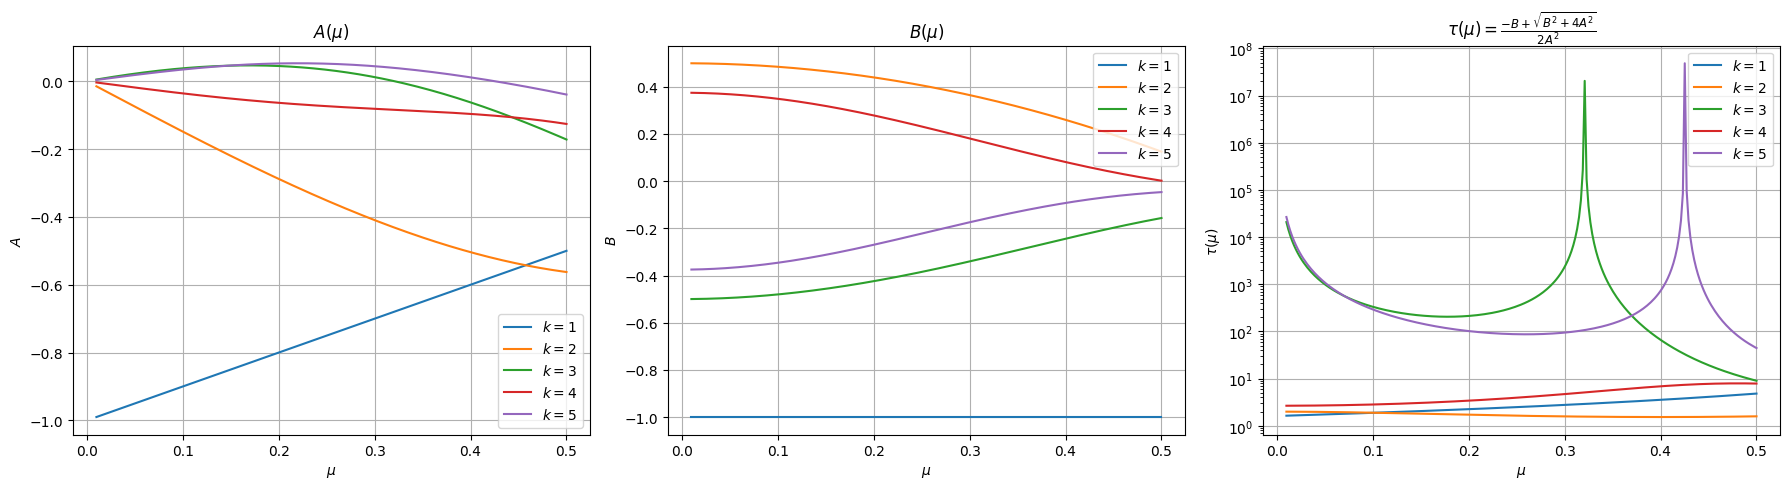

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import math

# (reuse your compute_A_B and sigma, sigma_r, bar_sigma_r definitions above)

# Sweep mu:
#mu_values = np.linspace(0.6, 0.9, 250)  # avoid mu=0 to avoid 0^k instability
mu_values = np.linspace(0.01, 0.5, 250)  # avoid mu=0 to avoid 0^k instability


# Choose the values of f_k to compare:
f_k_values = [1,2, 3, 4, 5] #, 2, 3, 4, 5] #[1, 2, 3, 4 ]#, 4, 5]
k_p_val = 0   # <-- fix or change as you like
a_1_val = 1.0
a_2_val = 0.0

A_results = {f: [] for f in f_k_values}
B_results = {f: [] for f in f_k_values}

for f_k_val in f_k_values:
    for mu_val in mu_values:
        A_val, B_val, _ = compute_A_B(mu=mu_val, k_star=f_k_val, r=mu_val**2)
        A_results[f_k_val].append(A_val)
        B_results[f_k_val].append(B_val)

# Convert to arrays
for f in f_k_values:
    A_results[f] = np.array(A_results[f]) #/(math.factorial(f)*f)
    B_results[f] = np.array(B_results[f]) #/(math.factorial(f)*f)

# ------------------ PLOTTING -------------------

plt.figure(figsize=(18,5))

# 1) Plot A(mu)
plt.subplot(1,3,1)
for f in f_k_values:
    plt.plot(mu_values, -A_results[f], label=fr'$k={f}$')
plt.title(r'$A(\mu)$')
plt.xlabel(r'$\mu$')
plt.ylabel(r'$A$')
plt.grid(True)
plt.legend()

# 2) Plot B(mu)
plt.subplot(1,3,2)
for f in f_k_values:
    plt.plot(mu_values, B_results[f], label=fr'$k={f}$')
plt.title(r'$B(\mu)$')
plt.xlabel(r'$\mu$')
plt.ylabel(r'$B$')
plt.grid(True)
plt.legend()

# 3) Plot tau(mu)
plt.subplot(1,3,3)
for f in f_k_values:
    A = A_results[f]
    B = B_results[f]

    # Compute tau safely
    discriminant = B**2 + 4*A**2
    lambda_plus = (B + np.sqrt(discriminant)) / (2*A**2)
    tau = 1 / lambda_plus

    # Alternatively directly: tau = (-B + sqrt(...)) / (2*A^2)
    tau_alt = (-B + np.sqrt(discriminant)) / (2*A**2)

    # Choose tau_alt to match your exact analytical definition:
    tau = tau_alt

    # Avoid plotting infinities
    tau = np.where(np.isfinite(tau), tau, np.nan)

    plt.plot(mu_values, tau, label=fr'$k={f}$')

plt.title(r'$\tau(\mu) = \frac{-B + \sqrt{B^2 + 4A^2}}{2A^2}$')
plt.yscale("log")
plt.xlabel(r'$\mu$')
plt.ylabel(r'$\tau(\mu)$')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

Hermite coefficients for erf: [np.float64(0.0014409781500671955), np.float64(0.5620599552360426), np.float64(0.0009000418331255657), np.float64(-0.04740762384317363)]
Hermite coefficients for relu: [np.float64(0.3982182809352773), np.float64(0.49906681267365044), np.float64(0.19889861291124117), np.float64(-0.00044331086600925507)]


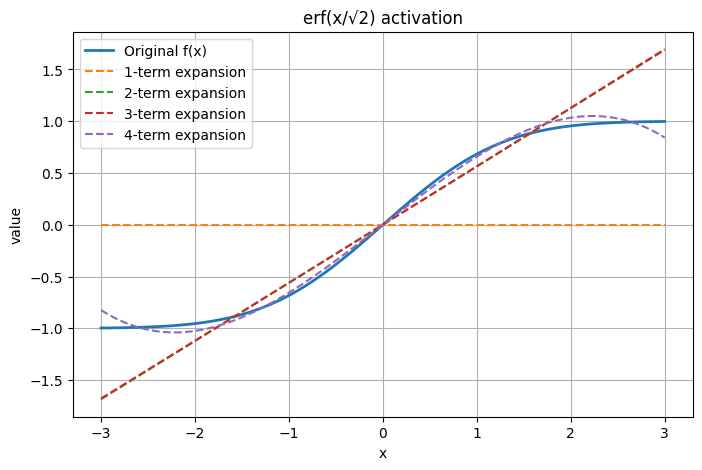

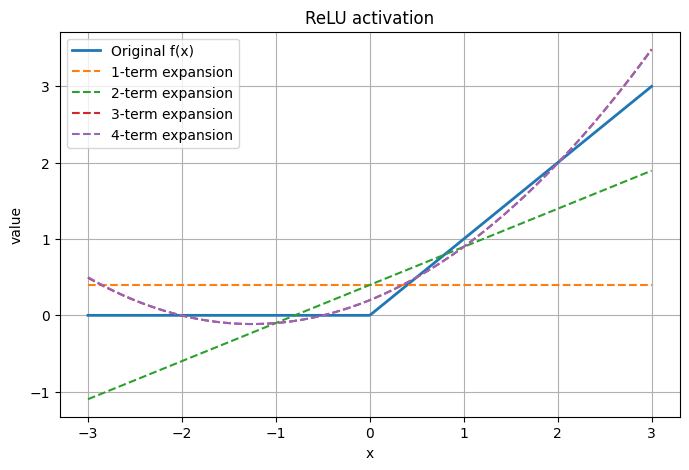

In [222]:
import numpy as np
import matplotlib.pyplot as plt
from math import factorial
from math import erf

# --------------------------------------------------
# Define activation functions
# --------------------------------------------------

def f_erf(x):
    return np.vectorize(erf)(x / np.sqrt(2))

def f_relu(x):
    return np.maximum(x, 0)

# --------------------------------------------------
# Probabilists' Hermite polynomials He_n(x)
# --------------------------------------------------
He = [
    lambda x: np.ones_like(x),                # He_0(x) = 1
    lambda x: x,                              # He_1(x) = x
    lambda x: x**2 - 1,                       # He_2(x) = x^2 - 1
    lambda x: x**3 - 3*x,                     # He_3(x)
    lambda x: x**4 - 6*x**2 + 3               # He_4(x)
]

# --------------------------------------------------
# Function to compute Hermite coefficients a_n
# --------------------------------------------------
def hermite_coeffs(f, num_terms=4, N=200000):
    X = np.random.randn(N)
    coeffs = []
    for n in range(num_terms):
        a_n = np.mean(f(X) * He[n](X)) / factorial(n)
        coeffs.append(a_n)
    return coeffs

# --------------------------------------------------
# Compute coefficients
# --------------------------------------------------
coeffs_erf = hermite_coeffs(f_erf, num_terms=4)
coeffs_relu = hermite_coeffs(f_relu, num_terms=4)

print("Hermite coefficients for erf:", coeffs_erf)
print("Hermite coefficients for relu:", coeffs_relu)

# --------------------------------------------------
# Plot function and Hermite approximations
# --------------------------------------------------
def hermite_approx(x, coeffs):
    approx = np.zeros_like(x)
    for n, a in enumerate(coeffs):
        approx += a * He[n](x)
    return approx

x = np.linspace(-3, 3, 400)

f_list = [(f_erf, coeffs_erf, "erf(x/√2) activation"),
          (f_relu, coeffs_relu, "ReLU activation")]

for f, coeffs, title in f_list:
    plt.figure(figsize=(8,5))
    plt.plot(x, f(x), label="Original f(x)", linewidth=2)

    for k in range(1,5):
        plt.plot(x, hermite_approx(x, coeffs[:k]), '--', label=f"{k}-term expansion")

    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("value")
    plt.grid(True)
    plt.legend()
    plt.show()

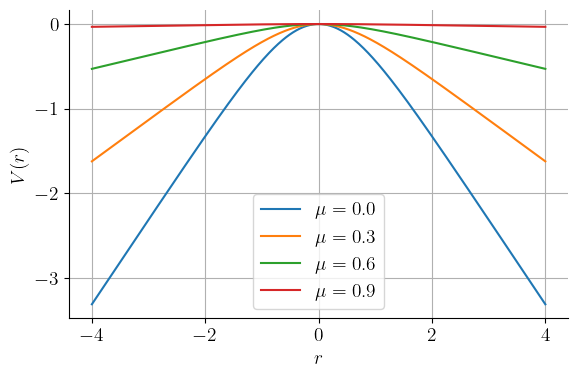

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# ICML-style plot settings
plt.rcParams.update({
    "text.usetex": True,
    "font.size": 14,
    "font.family": "serif",
    "axes.spines.top": False,
    "axes.spines.right": False
})

def V(r, mu):
    return - (1 - mu)**2 * np.log(np.cosh(r))

# Range of r
r = np.linspace(-4, 4, 400)

# Different values of mu
mus = [0.0, 0.3, 0.6, 0.9]

fig, ax = plt.subplots(figsize=(6, 4))

for mu in mus:
    ax.plot(r, V(r, mu), label=rf"$\mu = {mu}$")

ax.set_xlabel(r"$r$")
ax.set_ylabel(r"$V(r)$")
#ax.set_title(r"Potential $V(r) = -(1-\mu)^2 \log \cosh(r)$")
ax.legend(frameon=True)
ax.grid(True)  # remove grid for cleaner ICML look

plt.tight_layout()
plt.savefig("linear_potential.pdf")
plt.show()